In [1]:
import pandas as pd
import numpy as np
from numpy import *
import random
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn import decomposition
%matplotlib inline

C:\Users\Francesco\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing data

- In this first part we are going to preproces our data in order to perform, later, the analysis. In particular, we are going to define 4 functions that we need:<br>
    - import_function = that import the .csv files
    - f_organize = that transposes and rolls the df
    - function_name = that add the names to the columns
    - reduce_frequency = that reduce the frequency   

In [ ]:
#define a function that transposes and rolls the data

def f_organize(df,n,z):# n = number of rolls; z=lnly for first iteration in order to get the first 3 columns.
        
    df1 = df.iloc[:,3:]
    df1 = df1.transpose()
    df1 = df1.rolling(n).mean()
    df1 = df1.fillna(method='bfill') #'ffill'= stands for 'forward fill'
    df1 = df1.fillna(method='ffill') # 'bfill' = stands for 'backwards fill'
    df1 = df1.transpose()
    if z == 0:#we need the first 3 columns only from one df and not from all of them.
        df_info = df.iloc[:,0:3]
        df2 = pd.concat([df_info, df1], axis=1, sort=False)
    else:
        df2 = df1 
    return(df2)

In [ ]:
def function_name(df,d):
    labels1 = ['gesture','participanNr','sampleNr']
    labels=['accelleration_value_'+str(m) for m in range(1,1273)]
    if d == 0:
        labels=labels[0:424]#labels from 1 up to 424
        for p in range(3):
            labels.insert(p, labels1[p])
        df.columns = labels
    elif d == 1:
        labels=labels[424:848] # labels from 425 upto 848
        for r in range(3):
            labels.insert(r,labels1[r])
        df.columns = labels
    else:
        labels=labels[848:] # labels from 849 upto 1272
        for v in range(3):
            labels.insert(v,labels1[v])
        df.columns = labels
    return(df)

In [ ]:
# import the .csv files
def import_function():
    xyz=['x','y','z']
    df_list=[] # empty list where we are about to store the three .csv files
    for d in range(3):
        read_df = pd.read_csv('raw_data_wear_'+str(xyz[d])+'.csv', header=None) # we read the files
        read_df = function_name(read_df,d)
        df_list.append(f_organize(read_df,30,d)) # we apply our function to roll and clean the .csv

    df = pd.concat(df_list, axis = 1, sort=False) # we store the three files into one DataFrame.
    return(df)

In [ ]:
# from 50Hz to 25Hz
def reduce_frequency(df):
    for n in range(1,1273):
        if n%2==0:
            df.drop('accelleration_value_'+str(n), axis=1, inplace=True)
        else:
            continue
    return (df)

In [ ]:
df = reduce_frequency(import_function())

In [ ]:
df.to_csv('gestures.csv',index = None, header=True, encoding='utf-8')

## pca and data splitting
- pca_function = is the function to apply PCA

In [2]:
df = pd.read_csv('gestures.csv')

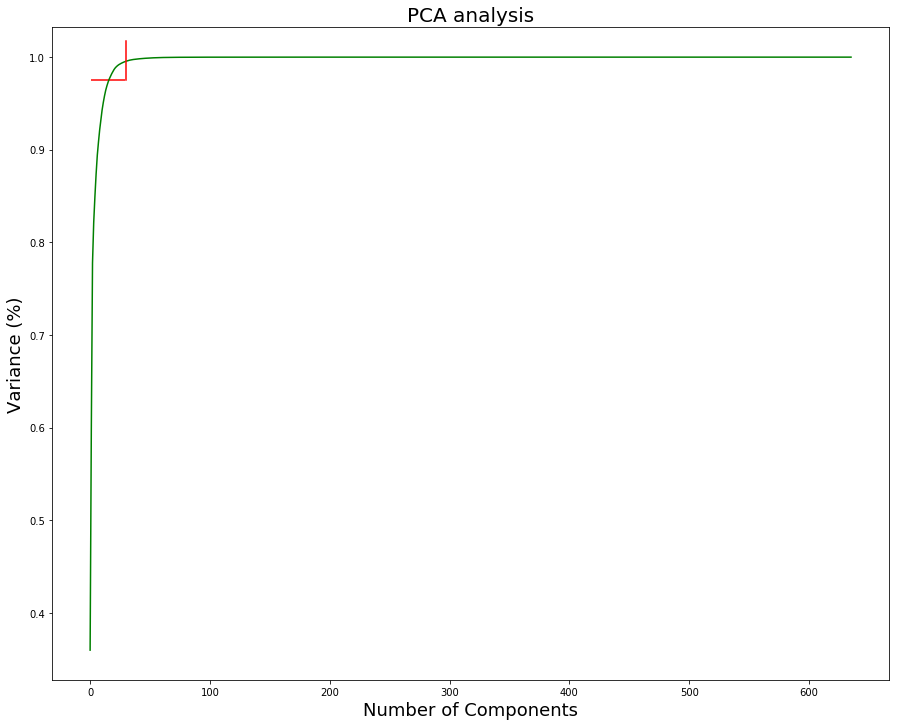

In [3]:
#Fit the PCA algorithm with our Data
pca = PCA().fit(df.iloc[:,3:])

fig, ax = plt.subplots(figsize = (15,12))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='green')
plt.title('PCA analysis', fontsize = 20)
plt.xlabel('Number of Components', fontsize = 18)
plt.ylabel('Variance (%)', fontsize = 18)

ax.axvline(x=30, ymin=0.92, ymax=0.98,color='red')
ax.hlines(y=0.975, xmin=0.88, xmax=29, color='red')

plt.savefig('PCA_selection.png')
plt.show()

In [4]:
def pca_function(Data_Frame, components, position):
    movements = {'left':1,'right':2, 'up':3, 'down':4, 'square':5, 'triangle':6, 'circleCw':7, 'circleCcw':8}
    
    pca = PCA(n_components=components)#we decide the number of components
    pca.fit(Data_Frame.iloc[:,position:])
    #we apply pca to the data (excluding the 'Label' column)
    pca_data = pca.transform(Data_Frame.iloc[:,position:])
    
    data_target=Data_Frame.iloc[:,0:position]# series of all the labels
    pca_dataframe = pd.DataFrame(pca_data)
    mergedDf = data_target.merge(pca_dataframe, left_index=True, right_index=True)
    mergedDf.gesture = [movements[m] for m in mergedDf.gesture]# from string to integer. We need for ML algorithms
    
    return(mergedDf)

In [5]:
df = pca_function(df, 30, 3)

In [6]:
X = df.iloc[:,3:] # we take only the values
y = df.iloc[:,0] # we take the label
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) # we split the df in train(80%) and test(20%) set

## Hyperparameter tuning

- In this section there is the Hyperparameter tuning. The process will end up by selecting the best model paramiters per each model.

In [ ]:
classifiers = {
    'knn':KNeighborsClassifier(),
    'dtc': DecisionTreeClassifier(),
    'svm': SVC(),
    'rf': RandomForestClassifier()
              }
paramiters = {
    'knn':{'n_neighbors':[int(x) for x in np.linspace(1, 200, num = 5)], 'weights':['uniform','distance']},
    
    'dtc':{'max_depth':[5,10], 'max_features':[int(x) for x in np.linspace(1, 25, num = 5)]},
    
    'svm': [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2,1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
    
    'rf': {
        'n_estimators': [int(x) for x in np.linspace(10,500, num = 3)],
        'max_depth': [int(x) for x in np.linspace(10, 100, 3)],
        'bootstrap': [True,False]
        
    }
          }

In [ ]:
gs_scores = {} # dictionary where will be stored all the scores
gs_paramiters = {} # dictionary where will be stored all the tested paramiters 
gs_estimators = {} # dictionary where will be stored all the estimators
for k in classifiers.keys():# we run up to all the models are tuned
    grid = GridSearchCV(
        classifiers[k], 
        paramiters[k], 
        cv = KFold(n_splits=10, random_state=25, shuffle=True), 
        scoring = 'accuracy')
    
    grid.fit(X_train,y_train)
    gs_scores[k] = grid.grid_scores_
    gs_paramiters[k] = grid.best_params_
    gs_estimators[k] = grid.best_estimator_

## Prediction and Accuracy

- Now, let's make the prediction by using the models, previously tuned, and let's look for the best predictive model for the gesture recognition challenge. 

In [7]:
mean_results = defaultdict() # dictionary where we are going to store the accuracy for each model
confusion_matrices = defaultdict() # we store the confusion matrix that later we'll plot
cross_validation = defaultdict()
classifier_dict = {'knn':KNeighborsClassifier(n_neighbors = 1, weights = 'distance'),
                   'svm': SVC(C = 10, gamma = 0.001, kernel = 'rbf'),
                   'dtc': DecisionTreeClassifier(max_depth = 10, max_features = 23),
                   'rf': RandomForestClassifier(bootstrap = False, max_depth = 100, n_estimators = 500),
                   'gnb': GaussianNB()
                  }

    
for k in classifier_dict.keys(): # now we call, one by one, all the models
    model_selected = classifier_dict[k] # we select the model
    cross_validation_score = cross_val_score(model_selected, X_train, y_train, cv=10)
    model_selected.fit(X_train,y_train) # we fit the model with the train set
    y_prediction = model_selected.predict(X_test) # we make the prediction
    
    cross_validation[k] = cross_validation_score.tolist() # store cross validation scores
    mean_results[k] = accuracy_score(y_test,y_prediction) # store accuracy
    confusion_matrices[k] = confusion_matrix(y_test, y_prediction) # store confusion matrices
        

## Print the results
- the first plot shows the CV results per each model
- the second plot shows the confusion matrices per each model
- the third plot shows the confusion matrix for the best model selected

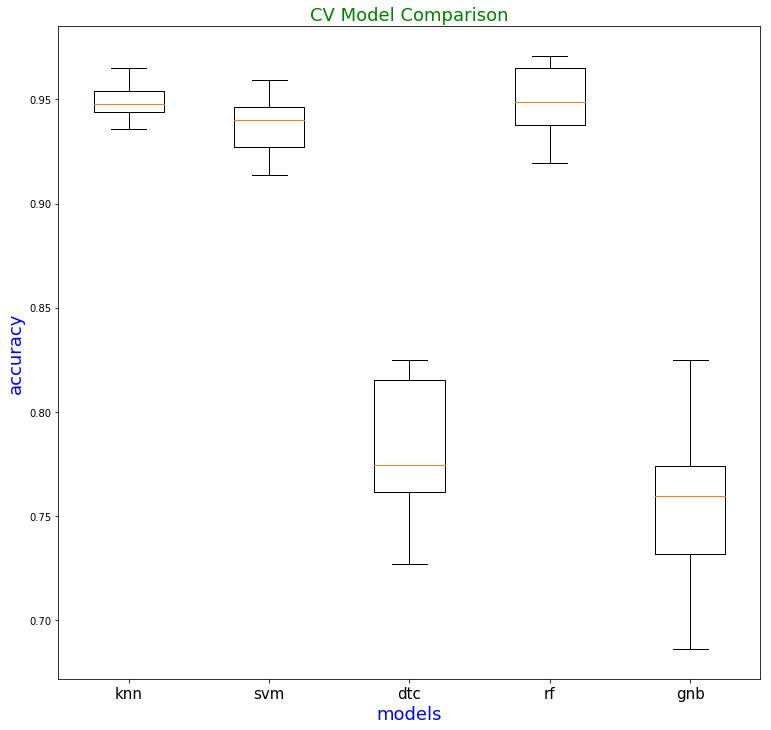

In [8]:
labels, data = [*zip(*cross_validation.items())] 
labels, data = cross_validation.keys(), cross_validation.values()

plt.figure(figsize = (15,12))
plt.subplots_adjust(left=0.25)
plt.boxplot(data)
plt.title('CV Model Comparison', fontsize=18, color = 'green')
plt.xticks(range(1, len(labels) + 1), labels, fontsize = 15)
plt.xlabel('models', fontsize=18).set_color("Blue")
plt.ylabel('accuracy', fontsize=18).set_color("Blue")

plt.savefig('models_accuracies.png')
plt.show()

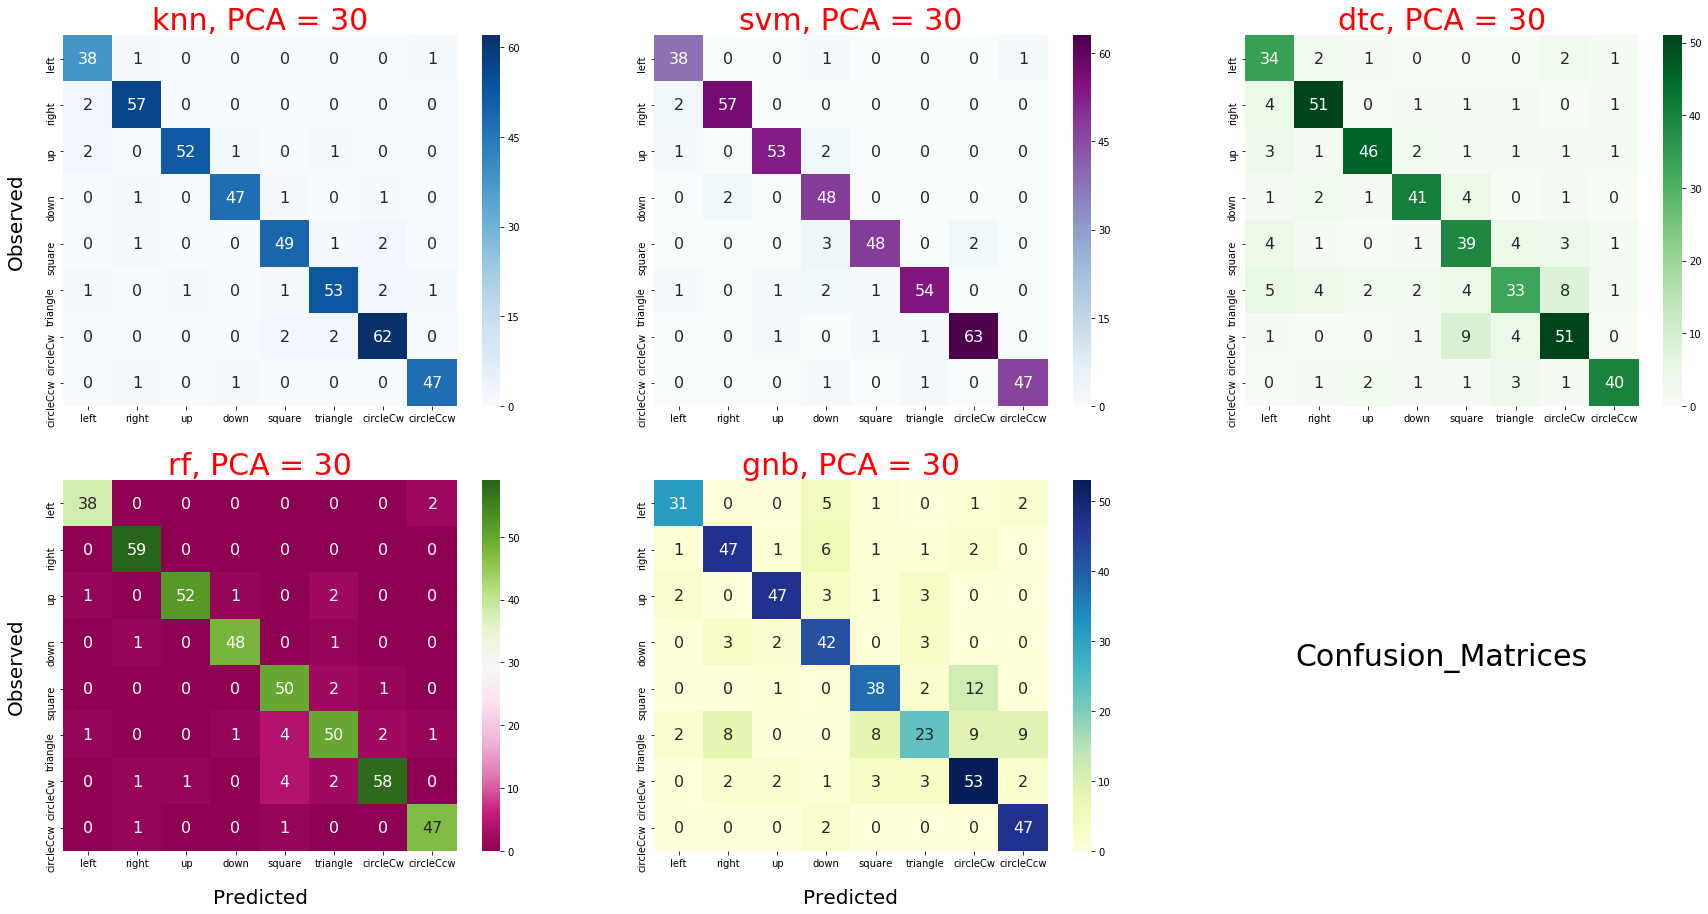

In [9]:
colors_map = ['Blues', 'BuPu', 'Greens', 'PiYG', 'YlGnBu']
movements = ['left','right', 'up', 'down', 'square', 'triangle', 'circleCw', 'circleCcw']

fig = plt.figure(figsize=(30,15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(confusion_matrices['knn'], cmap= 'Blues', annot=True,annot_kws={"size": 16}, ax=ax1)

sns.heatmap(confusion_matrices['svm'], cmap= 'BuPu', annot=True,annot_kws={"size": 16}, ax=ax2)
sns.heatmap(confusion_matrices['dtc'], cmap= 'Greens', annot=True,annot_kws={"size": 16}, ax=ax3)
sns.heatmap(confusion_matrices['rf'], cmap= 'PiYG', annot=True,annot_kws={"size": 16}, ax=ax4)
sns.heatmap(confusion_matrices['gnb'], cmap= 'YlGnBu', annot=True,annot_kws={"size": 16}, ax=ax5)
plt.text(16, 4, 'Confusion_Matrices', fontsize=30, ha='center')
labels_list=[ax1,ax2,ax3,ax4,ax5]
for n, (k,v) in enumerate(mean_results.items()):
    labels_list[n].set_title(k+str(', PCA = 30'), color='Red', fontsize=30)
    labels_list[n].set_xticklabels(movements)
    labels_list[n].set_yticklabels(movements)
ax1.set(ylabel='Observed')
ax1.yaxis.labelpad = 20
ax1.yaxis.label.set_size(20)
ax4.set(xlabel='Predicted', ylabel='Observed')
ax4.yaxis.labelpad = 20
ax4.xaxis.labelpad = 20
ax4.yaxis.label.set_size(20)
ax4.xaxis.label.set_size(20)
ax5.set(xlabel='Predicted')
ax5.xaxis.labelpad = 20
ax5.xaxis.label.set_size(20)
plt.savefig('confusions_matrices2_MAX_PCA.png')

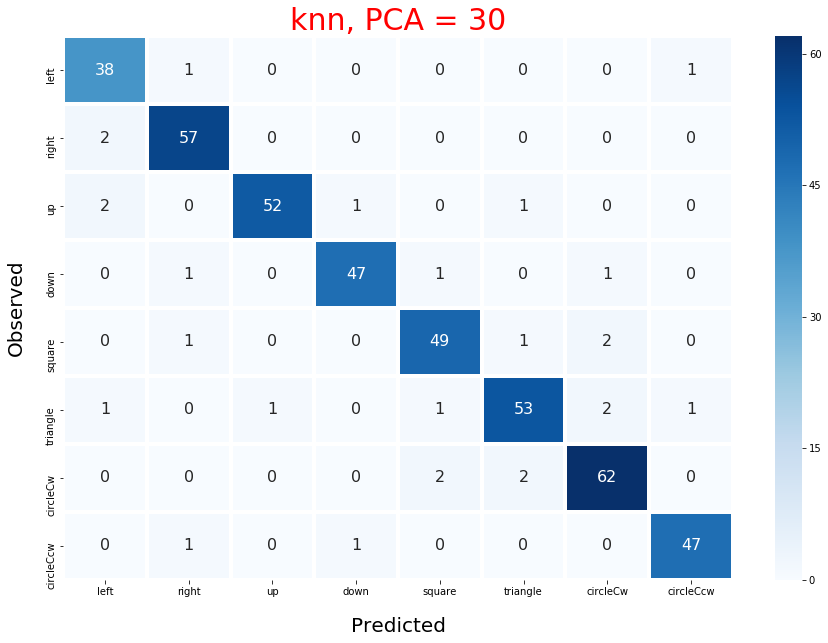

In [10]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrices['knn'], xticklabels = movements, yticklabels = movements, cmap= 'Blues', annot=True, annot_kws={"size": 16}, linewidth=3, ax =ax);
ax.set_title('knn, PCA = 30', color='Red', fontsize=30)
ax.set(xlabel='Predicted', ylabel='Observed')
ax.yaxis.labelpad = 20
ax.xaxis.labelpad = 20
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig('knn_matrix_PCA_30.png')